In [98]:
import numpy as np 
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100
import pygimli as pg
import pygimli.meshtools as mt
import pygimli.solver as ps
# from scipy.sparse.linalg import spsolve

In [99]:
T = 0.1
w = 2 * np.pi / T 
sigma0 = 1e-3
mu0 = np.pi * 4e-7

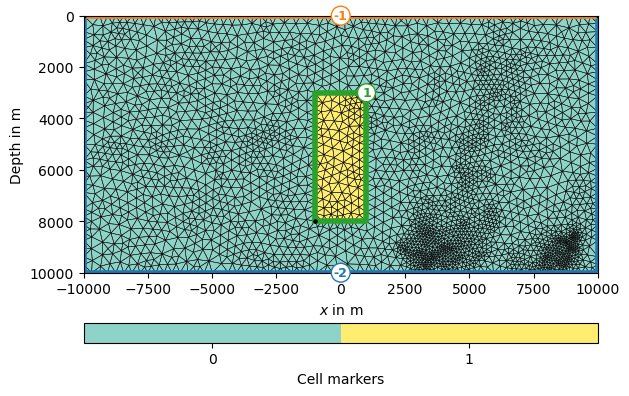

In [100]:
world = mt.createWorld(start=[-10000, -10000], end=[10000, 0], marker=0)
anomaly = mt.createRectangle(start=[-1000, -8000], end=[1000, -3000], marker=1)
mesh = mt.createMesh(world+anomaly, quality=34.4, smooth=True, area=1e5)
pg.show(mesh, markers=True, showMesh=True);

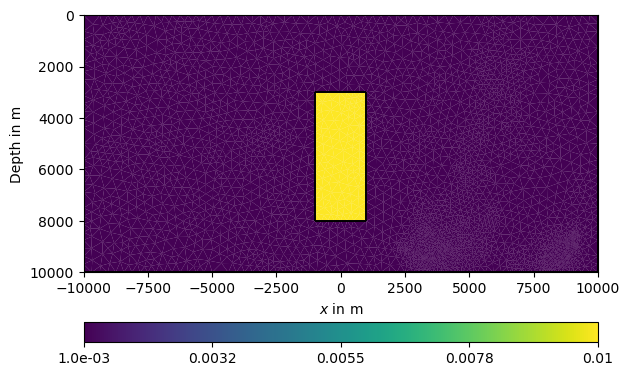

In [101]:
sigma = mesh.populate("sigma", {0: sigma0, 1: sigma0*10})
pg.show(mesh, "sigma");

In [102]:
def showResult2(mesh, u, mm=1, anomaly=None):
    fig, ax = plt.subplots(ncols=2, figsize=(8, 4), sharex=True, sharey=True)
    pg.show(mesh, np.real(u), ax=ax[0], nLevs=12, cMap="bwr", cMin=-mm, cMax=mm)
    pg.show(mesh, np.imag(u), ax=ax[1], nLevs=12, cMap="bwr", cMin=-mm, cMax=mm)
    if anomaly is not None:
        for a in ax:
            pg.show(anomaly, ax=a, fillRegion=False);

In [103]:
def showResult4(mesh, u, mm=1, anomaly=None):
    fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(6, 6), sharex=True, sharey=True)
    pg.show(mesh, np.real(u), ax=ax[0, 0], nLevs=12, cMap="bwr", cMin=-mm, cMax=mm)
    pg.show(mesh, np.imag(u), ax=ax[0, 1], nLevs=12, cMap="bwr", cMin=-mm, cMax=mm)
    pg.show(mesh, np.abs(u), ax=ax[1, 0], nLevs=12, cMap="Spectral_r")#, cMin=-mm, cMax=mm)
    pg.show(mesh, np.deg2rad(np.angle(u)), ax=ax[1, 1], nLevs=11, cMap="hsv", cMin=-45, cMax=45)
    if anomaly is not None:
        for a in ax.flat:
            pg.show(anomaly, ax=a, fillRegion=False);
    return ax

In [104]:
def analyticalSolution(mesh, sigma, mu=mu0):
    z = -pg.y(mesh)
    k = np.sqrt(-sigma*mu*w*1j)
    H = np.exp(-1j*k*z)
    H[z < 0] = 1
    return H

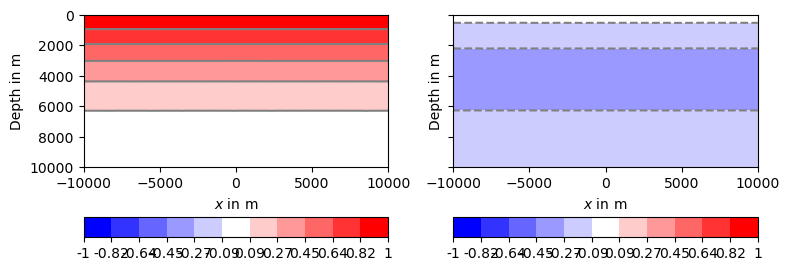

In [105]:
u0 = analyticalSolution(mesh, sigma0)
showResult2(mesh, u0);

In [106]:
A = ps.createStiffnessMatrix(mesh)
M = ps.createMassMatrix(mesh, mesh["sigma"]*mu0)
b = np.zeros(mesh.nodeCount())
bc = dict(Dirichlet={-1: 1.0})
ps.assembleBC(bc, mesh, A,  b);

In [107]:
C = pg.core.CSparseMatrix(A.vecColPtr(), A.vecRowIdx(), 
                          pg.core.toComplex(A.vecVals(), M.vecVals()*w))
c = pg.core.toComplex(b, b*0)
u = ps.linSolve(C, c)

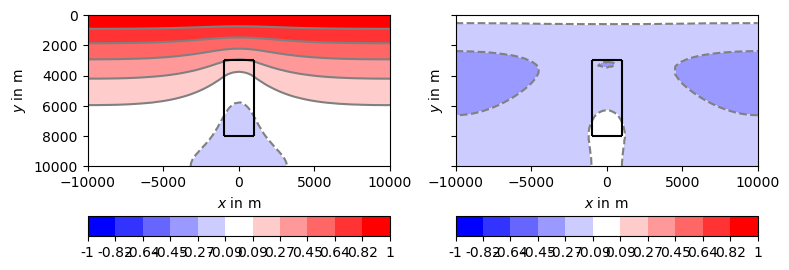

In [108]:
showResult2(mesh, u, anomaly=anomaly)

In [109]:
ndof = mesh.nodeCount()
B = pg.BlockMatrix()
B.Aid = B.addMatrix(A)
B.Mid = B.addMatrix(M)
B.addMatrixEntry(B.Aid, 0, 0)
B.addMatrixEntry(B.Aid, ndof, ndof)
B.addMatrixEntry(B.Mid, 0, ndof, scale=-w)
B.addMatrixEntry(B.Mid, ndof, 0, scale=w)

In [110]:
uRI = ps.linSolve(B, np.hstack([b, b*0]))
u = uRI[:mesh.nodeCount()].array() + uRI[mesh.nodeCount():].array() * 1j

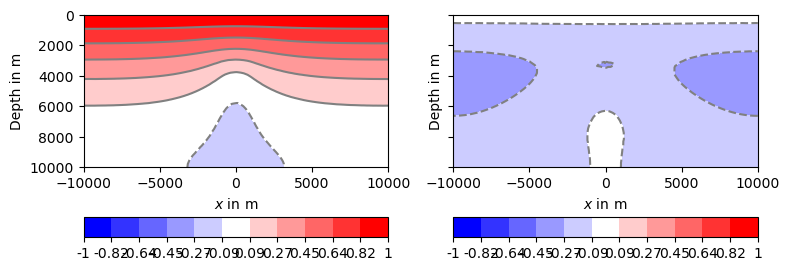

In [111]:
showResult2(mesh, u)

In [112]:
dM = ps.createMassMatrix(mesh, (mesh["sigma"]-sigma0)*mu0)
rhsI = -dM.dot(u0.real) * w
rhsR = dM.dot(u0.imag) * w
rhs = np.hstack([rhsR, rhsI])
uRI = ps.linSolve(B, rhs)
uS = uRI[:mesh.nodeCount()].array() + uRI[mesh.nodeCount():].array() * 1j

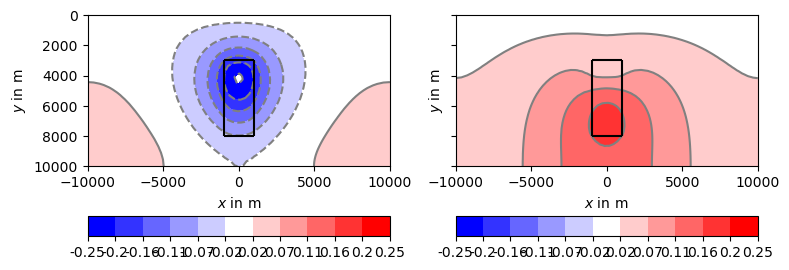

In [113]:
showResult2(mesh, uS, anomaly=anomaly, mm=0.25)

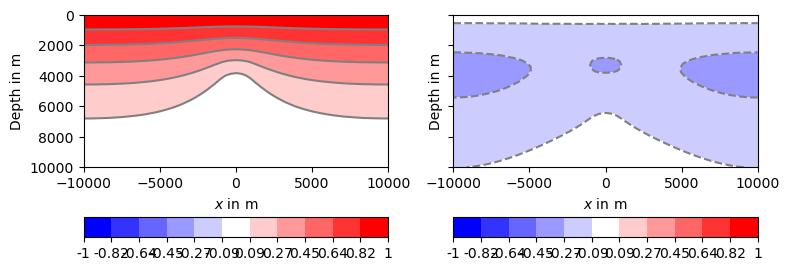

In [114]:
showResult2(mesh, u0+uS);